# Bag of Visual Words

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from google.colab import files
from PIL import Image
from tqdm import tqdm
import cv2
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.manifold import TSNE
from concurrent.futures import ThreadPoolExecutor, as_completed
import seaborn as sns

In [ ]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("andrewmvd/isic-2019")
print("Path to dataset files:", path)

100%|██████████| 9.10G/9.10G [01:45<00:00, 92.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/andrewmvd/isic-2019/versions/1


In [ ]:
metadata_path = os.path.join(path, "ISIC_2019_Training_Metadata.csv")
labels_path = os.path.join(path, "ISIC_2019_Training_GroundTruth.csv")
metadata_df = pd.read_csv("/root/.cache/kagglehub/datasets/andrewmvd/isic-2019/versions/1/ISIC_2019_Training_Metadata.csv")
labels_df = pd.read_csv(labels_path)
# View the first few rows
print(metadata_df.head())
print(labels_df.head())

          image  age_approx anatom_site_general lesion_id     sex
0  ISIC_0000000        55.0      anterior torso       NaN  female
1  ISIC_0000001        30.0      anterior torso       NaN  female
2  ISIC_0000002        60.0     upper extremity       NaN  female
3  ISIC_0000003        30.0     upper extremity       NaN    male
4  ISIC_0000004        80.0     posterior torso       NaN    male
          image  MEL   NV  BCC   AK  BKL   DF  VASC  SCC  UNK
0  ISIC_0000000  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
1  ISIC_0000001  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
2  ISIC_0000002  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
3  ISIC_0000003  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
4  ISIC_0000004  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0


Image shape: (767, 1022, 3)


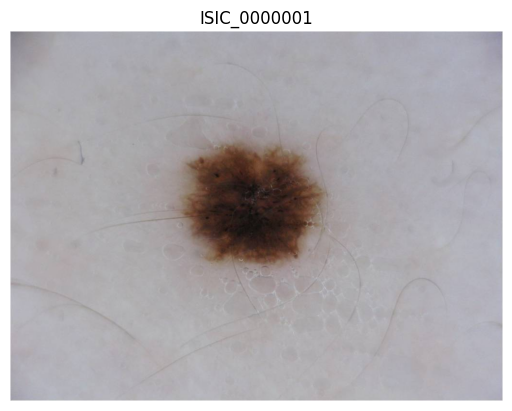

In [ ]:
image_ids = labels_df['image'].values
image_path = os.path.join(path, "ISIC_2019_Training_Input", "ISIC_2019_Training_Input", image_ids[1] + ".jpg")
image = Image.open(image_path)
image_np = np.array(image)
print("Image shape:", image_np.shape)
plt.imshow(image)
plt.axis('off')
plt.title(image_ids[1])
plt.show()

In [ ]:
extractor = cv2.ORB_create()
#extractor = cv2.SIFT_create()
descriptors_all = []
used_image_id_all = []
keypoints_all = []
for image_id in tqdm(image_ids):
    image_path = os.path.join(path, "ISIC_2019_Training_Input", "ISIC_2019_Training_Input", image_id + ".jpg")
    image = cv2.imread(image_path)
    if image is None:
        continue
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    keypoint, descriptor = extractor.detectAndCompute(gray, None)
    if descriptors_all is not None:
        descriptors_all.append(descriptor)
        used_image_id_all.append(image_id)
    keypoints_all.append(keypoint)

100%|██████████| 25331/25331 [09:48<00:00, 43.04it/s]


In [ ]:
labels_df_filtered_a = labels_df[labels_df['image'].isin(used_image_id_all)].copy()
labels_df_filtered_all = labels_df_filtered_a.set_index("image").loc[used_image_id_all]
y_all = labels_df_filtered_all["MEL"].values.astype(int)

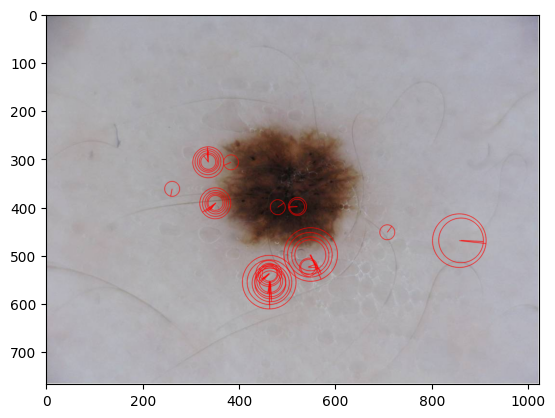

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
out_dir = os.path.expanduser("~/plots")
os.makedirs(out_dir, exist_ok=True)

first_image_path = os.path.join(path, "ISIC_2019_Training_Input", "ISIC_2019_Training_Input", image_ids[1] + ".jpg")
image = Image.open(first_image_path)
image_np = np.array(image)
output_image = cv2.drawKeypoints(image_np, keypoints_all[0], 0, (255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(output_image)
image_file = os.path.join(out_dir, "image0.png")
plt.savefig(image_file, bbox_inches="tight")
plt.show()

files.download(image_file)

In [ ]:
descriptor_list_all = []
for img_des in descriptors_all:
    if img_des is not None:
        descriptor_list_all.extend(img_des)
all_descriptors_all = np.vstack(descriptor_list_all)

In [ ]:
kmeans_all = MiniBatchKMeans(n_clusters=100, batch_size=100000)
kmeans_all.fit(all_descriptors_all)

MiniBatchKMeans(batch_size=100000, n_clusters=100)

In [ ]:
def build_bovw_histogram(descriptors, kmeans_model, k):
    histogram = np.zeros(k)
    if descriptors is not None:
        cluster_result = kmeans_all.predict(descriptors)
        for i in cluster_result:
            histogram[i] += 1
    return histogram

In [ ]:
bovw_features_all = []
for img_des in tqdm(descriptors_all):
    hist = build_bovw_histogram(img_des, kmeans_all, 100)
    bovw_features_all.append(hist)
bovw_features_all = np.array(bovw_features_all)

100%|██████████| 25331/25331 [00:16<00:00, 1552.94it/s]


In [ ]:
scaler = StandardScaler()
X_scaled_all = scaler.fit_transform(bovw_features_all)
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_scaled_all, y_all, test_size=0.2, random_state=42)

In [ ]:
lg = LogisticRegression()
lg.fit(X_train_all, y_train_all)
print(lg.score(X_test_all, y_test_all))
kneighbors = KNeighborsClassifier()
kneighbors.fit(X_train_all, y_train_all)
print(kneighbors.score(X_test_all, y_test_all))
linear_svm = SVC(kernel='linear')
linear_svm.fit(X_train_all, y_train_all)
print(linear_svm.score(X_test_all, y_test_all))
gauss_svm = SVC(kernel='rbf')
gauss_svm.fit(X_train_all, y_train_all)
print(gauss_svm.score(X_test_all, y_test_all))

0.8275113479376357
0.8125123347148214
0.8194197750148017
0.8314584566804816


# PCA

In [ ]:
labels_path = os.path.join(path, "ISIC_2019_Training_GroundTruth.csv")
labels_df = pd.read_csv(labels_path)
labels_df["image"] = labels_df["image"].astype(str)

# Prepare image file list
nested_folder = os.path.join(path, "ISIC_2019_Training_Input")
image_folder = os.path.join(nested_folder, "ISIC_2019_Training_Input")
if not os.path.exists(image_folder):
    image_folder = nested_folder

image_files = [
    os.path.join(image_folder, f)
    for f in os.listdir(image_folder)
    if f.lower().endswith(('.jpg', '.jpeg', '.png'))
]

print("Total images found:", len(image_files))

# Map to cancerous label
cancerous_cols = ["MEL", "BCC", "SCC"]
labels_df["cancerous"] = labels_df[cancerous_cols].max(axis=1)

def get_image_id(path):
    return os.path.splitext(os.path.basename(path))[0]

# Build labels array
labels = []
valid_files = []
for f in image_files:
    img_id = get_image_id(f)
    row = labels_df[labels_df["image"] == img_id]
    if len(row):
        labels.append(int(row["cancerous"].values[0]))
        valid_files.append(f)
labels = np.array(labels)
image_files = valid_files

print("Images with labels:", len(image_files))
print("Class distribution:", np.bincount(labels))

image_files, _, labels, _ = train_test_split(
     image_files, labels,
     train_size=2000,
     stratify=labels,
     random_state=42
)
print("After sampling:", len(image_files), "images")

# Improved SIFT configuration
sift = cv2.SIFT_create(contrastThreshold=0.005, edgeThreshold=20)
MAX_DESC = 1000  # increase cap

def process_image(path, target_size=(300,300)):
    img = cv2.imread(path)
    if img is None: return None
    img = cv2.resize(img, target_size)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, descriptors = sift.detectAndCompute(gray, None)
    if descriptors is not None and descriptors.shape[0] > MAX_DESC:
        idx = np.random.choice(descriptors.shape[0], MAX_DESC, replace=False)
        descriptors = descriptors[idx]
    return descriptors

# Extract descriptors
all_desc = []
with ThreadPoolExecutor(max_workers=8) as ex:
    futures = {ex.submit(process_image, f): f for f in image_files}
    for future in tqdm(as_completed(futures), total=len(futures)):
        d = future.result()
        if d is not None and d.size>0:
            all_desc.append(d)
all_desc = np.vstack(all_desc)
print("Total SIFT descriptors:", all_desc.shape)

# PCA + whitening
pca = PCA(n_components=64, whiten=True)
desc_red = pca.fit_transform(all_desc)
print("Descriptors after PCA:", desc_red.shape)

# KMeans codebook
num_clusters = 128
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(desc_red)

# Soft-assignment histogram builder
from sklearn.metrics import pairwise_distances
def build_hist(path, top_k=3):
    desc = process_image(path)
    if desc is None or desc.size==0:
        return np.zeros(num_clusters)
    desc_r = pca.transform(desc)
    dists = pairwise_distances(desc_r, kmeans.cluster_centers_)
    h = np.zeros(num_clusters)
    for row in dists:
        nn = np.argsort(row)[:top_k]
        w = 1/(row[nn]+1e-6)
        w /= w.sum()
        h[nn] += w
    return h

# Build histograms
hists = []
with ThreadPoolExecutor(max_workers=8) as ex:
    futures = {ex.submit(build_hist, f): f for f in image_files}
    for future in tqdm(as_completed(futures), total=len(futures)):
        hists.append(future.result())
hists = np.array(hists)

# Normalize & scale
h_norm = normalize(hists, norm='l1', axis=1)
scaler = StandardScaler()
h_scaled = scaler.fit_transform(h_norm)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    h_scaled, labels, test_size=0.2, stratify=labels, random_state=100
)

# Classifiers
clfs = {
    "SVM": SVC(kernel='linear', probability=True, random_state=100),
    "KNN": KNeighborsClassifier(),
    "LogReg": LogisticRegression(max_iter=1000, random_state=100)
}

for name, clf in clfs.items():
    clf.fit(X_train, y_train)
    yp = clf.predict(X_test)
    print(f"\n{name} accuracy:", accuracy_score(y_test, yp))
    print(classification_report(y_test, yp))
    cv = cross_val_score(clf, h_scaled, labels, cv=5, n_jobs=-1)
    print(f"{name} CV acc: {cv.mean():.3f}±{cv.std():.3f}")
    prob = clf.predict_proba(X_test)[:,1]
    print(f"{name} ROC-AUC:", roc_auc_score(y_test, prob))

# t‑SNE for ORB
tsne_orb = TSNE(n_components=2, random_state=100, perplexity=30, n_iter=1000)
orb_tsne = tsne_orb.fit_transform(X_scaled_all)
plt.figure(figsize=(8, 6))
plt.scatter(orb_tsne[:, 0], orb_tsne[:, 1], s=30, c=y_all, cmap='coolwarm', alpha=0.7)
plt.title("t‑SNE of ORB-based BoVW Features")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar(label="Cancerous (1) vs Non-Cancerous (0)")
plt.show()

# Confusion Matrix for ORB SVM
y_pred_orb = linear_svm.predict(X_test_all)
cm_orb = confusion_matrix(y_test_all, y_pred_orb)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_orb, annot=True, fmt="d", cmap='Blues', cbar=False)
plt.title("Confusion Matrix — ORB-based Linear SVM")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# t‑SNE for SIFT
tsne_sift = TSNE(n_components=2, random_state=100, perplexity=30, n_iter=1000)
hist_2d_tsne = tsne_sift.fit_transform(hist_array_scaled)
plt.figure(figsize=(8, 6))
plt.scatter(hist_2d_tsne[:, 0], hist_2d_tsne[:, 1], s=30, c=labels, cmap='coolwarm', alpha=0.7)
plt.title("t‑SNE of SIFT-based BoVW Features")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar(label="Cancerous (1) vs Non-Cancerous (0)")
plt.show()

# Confusion Matrix for SIFT SVM
best_clf = classifiers["SVM"]
y_pred_best = best_clf.predict(X_test)
cm_sift = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_sift, annot=True, fmt="d", cmap='Blues', cbar=False)
plt.title("Confusion Matrix — SIFT-based Linear SVM")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
from google.colab import files  # Import Colab file utilities

# Define output directory (in Colab, work relative to /content)
out_dir = os.path.expanduser("~/plots")
os.makedirs(out_dir, exist_ok=True)

# --------------------------
# t‑SNE for ORB-based features
# --------------------------
tsne_orb = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
orb_tsne = tsne_orb.fit_transform(X_scaled_all)
plt.figure(figsize=(8, 6))
plt.scatter(orb_tsne[:, 0], orb_tsne[:, 1], s=30, c=y_all, cmap='coolwarm', alpha=0.7)
plt.title("t‑SNE of ORB-based BoVW Features")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar(label="Cancerous (1) vs Non-Cancerous (0)")
orb_tsne_file = os.path.join(out_dir, "tsne_orb.png")
plt.savefig(orb_tsne_file, bbox_inches="tight")
plt.show()

# Download the ORB-based t‑SNE plot
files.download(orb_tsne_file)

# --------------------------
# Confusion Matrix for ORB SVM
# --------------------------
y_pred_orb = linear_svm.predict(X_test_all)
cm_orb = confusion_matrix(y_test_all, y_pred_orb)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_orb, annot=True, fmt="d", cmap='Blues', cbar=False)
plt.title("Confusion Matrix — ORB-based Linear SVM")
plt.xlabel("Predicted")
plt.ylabel("True")
confusion_orb_file = os.path.join(out_dir, "confusion_orb_svm.png")
plt.savefig(confusion_orb_file, bbox_inches="tight")
plt.show()

# Download the ORB SVM confusion matrix
files.download(confusion_orb_file)

# --------------------------
# t‑SNE for SIFT-based features
# --------------------------
tsne_sift = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
hist_2d_tsne = tsne_sift.fit_transform(h_scaled)
plt.figure(figsize=(8, 6))
plt.scatter(hist_2d_tsne[:, 0], hist_2d_tsne[:, 1], s=30, c=labels, cmap='coolwarm', alpha=0.7)
plt.title("t‑SNE of SIFT-based BoVW Features")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar(label="Cancerous (1) vs Non-Cancerous (0)")
tsne_sift_file = os.path.join(out_dir, "tsne_sift.png")
plt.savefig(tsne_sift_file, bbox_inches="tight")
plt.show()

# Download the SIFT-based t‑SNE plot
files.download(tsne_sift_file)

# --------------------------
# Confusion Matrix for SIFT SVM
# --------------------------
best_clf = clfs["SVM"]
y_pred_best = best_clf.predict(X_test)
cm_sift = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_sift, annot=True, fmt="d", cmap='Blues', cbar=False)
plt.title("Confusion Matrix — SIFT-based Linear SVM")
plt.xlabel("Predicted")
plt.ylabel("True")
confusion_sift_file = os.path.join(out_dir, "confusion_sift_svm.png")
plt.savefig(confusion_sift_file, bbox_inches="tight")
plt.show()

# Download the SIFT SVM confusion matrix
files.download(confusion_sift_file)


# CNN

In [ ]:
import pandas as pd
import os

#load original data
original_groundtruth = pd.read_csv('/content/archive/ISIC_2019_Training_GroundTruth.csv')

images_folder = '/content/archive/ISIC_2019_Training_Input/ISIC_2019_Training_Input'
all_files = os.listdir(images_folder)
images = []
for file in all_files:
    if file.endswith('.jpg'): #dodge txt files in dataset
        images.append(file)

paths = []
for image in images:
  paths.append(os.path.join(images_folder, image))

original_groundtruth['class'] = 0

cancerous = ['MEL','BCC','SCC']

#assign class val 1 to all cancerous images
original_groundtruth.loc[
    (original_groundtruth['MEL'] == 1) | (original_groundtruth['BCC'] == 1) | (original_groundtruth['SCC'] == 1),
    'class'] = 1

#drop old label columns
old_labels = ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC', 'UNK']
original_groundtruth = original_groundtruth.drop(columns=old_labels)
original_groundtruth.rename(columns={'image': 'filename'}, inplace=True)
original_groundtruth['filename'] = paths
original_groundtruth['class'] = original_groundtruth['class'].astype(str) #str needed for tf/keras

cancerous_images = original_groundtruth[original_groundtruth['class'] == '1']
noncancerous_images = original_groundtruth[original_groundtruth['class'] == '0']

In [ ]:
import matplotlib.pyplot as plt

cancer_images = groundtruth[groundtruth['class'] == '1']
non_cancer_images = groundtruth[groundtruth['class'] == '0']

print(len(cancer_images))
print(len(non_cancer_images))

plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    img = plt.imread(cancer_images.iloc[i]['filename'])
    plt.imshow(img)
    plt.title('Cancer')
    plt.axis('off')
plt.show()

plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    img = plt.imread(non_cancer_images.iloc[i]['filename'])
    plt.imshow(img)
    plt.title('Non-Cancer')
    plt.axis('off')

In [ ]:
import cv2 as cv

#increase contrast in Y'UV colorspace for better border/color variation feature detection
def up_contrast(image):
  img = cv.imread(image)
  img_yuv = cv.cvtColor(img, cv.COLOR_BGR2YUV)
  img_yuv[:,:,0] = cv.equalizeHist(img_yuv[:,:,0])

  img_output = cv.cvtColor(img_yuv, cv.COLOR_YUV2BGR)
  return img_output

#resize images for better training efficiency/ensure uniformity
def resize(image):
  img = cv.imread(image)
  img = cv.resize(img, (224, 224))
  return img

for image in images:
  img = resize(os.path.join(images_folder, image))
  cv.imwrite(os.path.join(images_folder, image), img)

for image in images:
  img = up_contrast(os.path.join(images_folder, image))
  cv.imwrite(os.path.join(images_folder, image), img)

cancer_images2 = groundtruth[groundtruth['class'] == '1']
non_cancer_images2 = groundtruth[groundtruth['class'] == '0']

plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    img = plt.imread(cancer_images2.iloc[i]['filename'])
    plt.imshow(img)
    plt.title('Cancer')
    plt.axis('off')
plt.show()

plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    img = plt.imread(non_cancer_images2.iloc[i]['filename'])
    plt.imshow(img)
    plt.title('Non-Cancer')
    plt.axis('off')


In [ ]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(groundtruth, test_size=0.2, random_state=42)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#augment training images to mirror real-life variability in image data, randomized by epoch
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    vertical_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    #subset='training',
    #shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    #subset='validation',
    #shuffle=True
)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

#naive CNN trained from scratch

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [ ]:

model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
import numpy as np

y_true = val_generator.classes
y_pred = np.round(model.predict(val_generator))

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(classification_report(y_true, y_pred, target_names=['non-cancer', 'cancer']))

In [ ]:
#New grayscale-based processing and transfer learning approach w/ ResNet50 model

import os
import pandas as pd
import matplotlib.pyplot as plt

#load original data
original_groundtruth = pd.read_csv('/content/archive/ISIC_2019_Training_GroundTruth.csv')

images_folder = '/content/archive/ISIC_2019_Training_Input/ISIC_2019_Training_Input'
all_files = os.listdir(images_folder)
images = []
for file in all_files:
    if file.endswith('.jpg'): #dodge txt files in dataset
        images.append(file)

paths = []
for image in images:
  paths.append(os.path.join(images_folder, image))

original_groundtruth['class'] = 0

cancerous = ['MEL','BCC','SCC']

#assign class val 1 to all cancerous images
original_groundtruth.loc[
    (original_groundtruth['MEL'] == 1) | (original_groundtruth['BCC'] == 1) | (original_groundtruth['SCC'] == 1),
    'class'] = 1

#drop old label columns
old_labels = ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC', 'UNK']
original_groundtruth = original_groundtruth.drop(columns=old_labels)
original_groundtruth.rename(columns={'image': 'filename'}, inplace=True)
original_groundtruth['filename'] = paths
original_groundtruth['class'] = original_groundtruth['class'].astype(str) #str needed for tf/keras

cancerous_images = original_groundtruth[original_groundtruth['class'] == '1']
noncancerous_images = original_groundtruth[original_groundtruth['class'] == '0']

plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    img = plt.imread(original_groundtruth.iloc[i]['filename'])
    plt.imshow(img)
    plt.title('Original Imgs')
    plt.axis('off')
plt.show()

plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    img = plt.imread(original_groundtruth.iloc[i+5]['filename'])
    plt.imshow(img)
    plt.title('Original Imgs')
    plt.axis('off')
plt.show()

print(len(original_groundtruth))
print(len(cancerous_images))
print(len(noncancerous_images))


In [ ]:
import cv2
import numpy as np

#Preprocessing functions

def preprocess_image(image_path):
    #dull razor technique for hair removal from:
    #https://github.com/BlueDokk/Dullrazor-algorithm/blob/main/dullrazor.py
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
    blur = cv2.GaussianBlur(blackhat, (3, 3), cv2.BORDER_REPLICATE)
    _, mask = cv2.threshold(blur, 10, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    inpainted = cv2.inpaint(gray, mask, 6, cv2.INPAINT_TELEA)
    denoised = cv2.medianBlur(inpainted, ksize=5)
    denoised = cv2.bilateralFilter(denoised, d=5, sigmaColor=25, sigmaSpace=25)
    clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(8, 8))
    s_gray = clahe.apply(denoised)
    s_image = np.stack([s_gray] * 3, axis=-1)

    #crop out black borders technique from:
    #https://afetulhak.medium.com/crop-out-unwanted-border-pixels-from-medical-images-or-any-kind-of-image-b3def5dea2db
    threshold = cv2.threshold(s_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    contours, _ = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    if len(contours) == 0:
      return cv2.resize(s_image, (224, 224))
    x, y, w, h = cv2.boundingRect(contours[0])
    sc_image = cv2.resize(s_image[y:y+h, x:x+w], (224, 224))

    return sc_image

In [ ]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

dir = '/content/drive/MyDrive/dataset/preprocessed_images'
os.makedirs(dir, exist_ok=True)

preprocessed_images = []

#apply random augmentations
augment_image = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True
)

for _, row in cancerous_images.iterrows():
    path = row['filename']
    label = row['class']

    #apply preprocessing
    pp_img = preprocess_image(path)
    pp_img = pp_img.astype('float32') / 255.0
    pp_img = pp_img.reshape((1,) + pp_img.shape)

    for i, batch in enumerate(augment_image.flow(pp_img, batch_size=1, shuffle=False)):
        base = os.path.basename(path).split('.')[0]
        save_path = os.path.join(dir, f"{base}_preprocessed{i}.jpg")

        array_to_img(batch[0]).save(save_path)
        preprocessed_images.append({
              'filename': save_path,
              'class': '1'
          })
        if i == 1: #balance data by oversampling cancerous images 2:1 noncancerous
          break

for _, row in noncancerous_images.iterrows():
    path = row['filename']
    label = row['class']

    #apply preprocessing
    pp_img = preprocess_image(path)
    pp_img = pp_img.astype('float32') / 255.0
    pp_img = pp_img.reshape((1,) + pp_img.shape)

    for j, batch in enumerate(augment_image.flow(pp_img, batch_size=1, shuffle=False)):
        base = os.path.basename(path).split('.')[0]
        save_path = os.path.join(dir, f"{base}_preprocessed{j}.jpg")

        array_to_img(batch[0]).save(save_path)
        preprocessed_images.append({
          'filename': save_path,
          'class': '0'

        break

preprocessed_groundtruth = pd.DataFrame(preprocessed_images)
preprocessed_groundtruth.to_csv('/content/drive/MyDrive/preprocessed_groundtruth.csv', index=False)

In [ ]:
print(len(preprocessed_groundtruth))

preprocessed_cancerous_images = preprocessed_groundtruth[preprocessed_groundtruth['class'] == '1']
preprocessed_noncancerous_images = preprocessed_groundtruth[preprocessed_groundtruth['class'] == '0']

print(len(preprocessed_cancerous_images))
print(len(preprocessed_noncancerous_images))

random_canc_images = preprocessed_cancerous_images.sample(n=5)
random_noncanc_images = preprocessed_noncancerous_images.sample(n=5)

plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    img = plt.imread(random_canc_images.iloc[i]['filename'])
    plt.imshow(img)
    plt.title('Cancer Imgs')
    plt.axis('off')
plt.show()

plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    img = plt.imread(random_noncanc_images.iloc[i]['filename'])
    plt.imshow(img)
    plt.title('Noncancer Imgs')
    plt.axis('off')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

c_images = pp_gt[pp_gt['class'] == 1]
nc_images = pp_gt[pp_gt['class'] == 0]

sample_c_images = c_images.sample(n=5)
sample_nc_images = nc_images.sample(n=5)

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

#construct training data pipeline w/ RAM loaded images to improve training time

pp_gt['filename'] = pp_gt['filename'].apply(lambda x: x.replace(
    '/content/drive/MyDrive/dataset/preprocessed_images',
    '/content/preprocessed_images_zip/preprocessed_images'))
filepaths = pp_gt['filename'].values
labels = pp_gt['class'].astype(int).values

train_paths, val_paths, train_labels, val_labels = train_test_split(
    filepaths, labels, test_size=0.2, stratify=labels, random_state=42)

def decode_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (224, 224))
    return image, label

train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_ds = train_ds.shuffle(buffer_size=1024) \
                   .map(decode_image, num_parallel_calls=tf.data.AUTOTUNE) \
                   .batch(64) \
                   .prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_ds = val_ds.map(decode_image, num_parallel_calls=tf.data.AUTOTUNE) \
               .batch(64) \
               .prefetch(tf.data.AUTOTUNE)

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.regularizers import l2

#New model with ResNet50 base and three-layer dense head classifier

resnet_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

#freeze all ResNet50 layers
for layer in resnet_model.layers:
    layer.trainable = False

x = layers.GlobalAveragePooling2D()(resnet_model.output)
x = layers.Dropout(0.4)(x)
x = layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
output = layers.Dense(1, activation='sigmoid')(x)

my_model = models.Model(inputs=resnet_model.input, outputs=output)

my_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
my_model.fit(
    train_ds,
    validation_data=(val_ds),
    epochs=25,
)

In [ ]:
#unfreeze deepest 20 ResNet50 layers

for layer in my_model.layers[-20:]:
  layer.trainable = True

my_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.05),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
my_model.fit(
    train_ds,
    validation_data=(val_ds),
    epochs=25,
)

# Vision Transformers

### Step 0: Imports and Dataset Download

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

import timm  # For pretrained models, including Vision Transformer
from tqdm import tqdm  # For progress bars

Path to dataset files: /root/.cache/kagglehub/datasets/andrewmvd/isic-2019/versions/1


In [ ]:
# Download the dataset via kagglehub (assumes kagglehub is properly configured)
import kagglehub
path = kagglehub.dataset_download("andrewmvd/isic-2019")
print("Path to dataset files:", path)


### Step 1: Prepare the Dataset and Labels

In [ ]:

# Define paths to the CSV files and image directory
metadata_csv = os.path.join(path, "ISIC_2019_Training_Metadata.csv")
ground_truth_csv = os.path.join(path, "ISIC_2019_Training_GroundTruth.csv")
images_dir = os.path.join(path, "ISIC_2019_Training_Input", "ISIC_2019_Training_Input")

# Read the ground truth CSV.
labels_df = pd.read_csv(ground_truth_csv)

# Create a binary target column "cancer":
# An image is marked as cancerous (1) if any of the columns "MEL", "BCC", or "SCC" is positive.
labels_df["cancer"] = (labels_df[['MEL', 'BCC', 'SCC']].sum(axis=1) > 0).astype(int)

# Create a new column for the full image file paths.
labels_df["file_path"] = labels_df["image"].apply(lambda x: os.path.join(images_dir, x + ".jpg"))

### Step 2: Split the Data into Training, Validation, and Test Sets

In [ ]:
train_val_df, test_df = train_test_split(
    labels_df,
    test_size=0.2,
    random_state=42,
    stratify=labels_df['cancer']
)

# Further split the training+validation set into training (90%) and validation (10%).
train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.1,
    random_state=42,
    stratify=train_val_df['cancer']
)

print("Training set distribution:")
print(train_df['cancer'].value_counts())
print("\nValidation set distribution:")
print(val_df['cancer'].value_counts())
print("\nTest set distribution:")
print(test_df['cancer'].value_counts())

              image  MEL   NV  BCC   AK  BKL   DF  VASC  SCC  UNK  \
0      ISIC_0000000    0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0   
1      ISIC_0000001    0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0   
2      ISIC_0000002    1  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0   
3      ISIC_0000003    0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0   
4      ISIC_0000004    1  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0   
...             ...  ...  ...  ...  ...  ...  ...   ...  ...  ...   
25326  ISIC_0073247    0  0.0  1.0  0.0  0.0  0.0   0.0  0.0  0.0   
25327  ISIC_0073248    0  0.0  0.0  0.0  1.0  0.0   0.0  0.0  0.0   
25328  ISIC_0073249    1  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0   
25329  ISIC_0073251    0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0   
25330  ISIC_0073254    0  0.0  0.0  0.0  1.0  0.0   0.0  0.0  0.0   

                                               file_path  cancer  
0      /root/.cache/kagglehub/datasets/andrewmvd/isic...       0  
1      /root/.cache/kagglehub/dataset

### Step 3: Create a custom pytorch dataset

In [ ]:
class ISICDataset(Dataset):
    def __init__(self, df, transform=None):
        """
        Args:
            df (DataFrame): DataFrame with columns "file_path" and "cancer".
            transform: torchvision transforms to apply.
        """
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row["file_path"]
        label = int(row["cancer"])

        # Load image and convert to RGB
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

### Step 4: Define Transforms and DataLoaders

In [ ]:
input_size = 224

# Transformations for training (including data augmentation)
train_transform = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    # Normalization using the same statistics as used during model pretraining.
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Transformations for validation and testing (only resize and normalization)
test_transform = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

batch_size = 32

# Create datasets
train_dataset = ISICDataset(train_df, transform=train_transform)
val_dataset   = ISICDataset(val_df, transform=test_transform)
test_dataset  = ISICDataset(test_df, transform=test_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

Training set distribution:
cancer
0    13486
1     6778
Name: count, dtype: int64

Test set distribution:
cancer
0    3372
1    1695
Name: count, dtype: int64


### Step 3: Data class

In [ ]:
class ISICDataset(Dataset):
    def __init__(self, df, transform=None):
        """
        Args:
            df (DataFrame): DataFrame with columns "file_path" and "cancer".
            transform: torchvision transforms to apply.
        """
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row["file_path"]
        label = int(row["cancer"])

        # Open image and convert to RGB
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label


### Step 4: Transforms + DataLoaders

In [ ]:
input_size = 224

train_transform = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    # Normalization values should match those used during pretraining of the model.
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

batch_size = 32

train_dataset = ISICDataset(train_df, transform=train_transform)
test_dataset  = ISICDataset(test_df, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


### Step 5: Setup the Model, Loss, and Optimizer

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create the Vision Transformer model with pretrained weights.
# The model is set to output 2 classes for binary classification.
model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=2)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

### Step 6: Training Loop (with Validation)

In [ ]:
num_epochs = 5
for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}")

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    val_acc = 100.0 * correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Validation Accuracy: {val_acc:.2f}%")


Epoch 1/5 - Training:  22%|██▏       | 112/507 [1:58:11<6:50:27, 62.35s/it]

### Step 7: Test evaluation

In [ ]:
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (preds == labels).sum().item()

test_acc = 100.0 * test_correct / test_total
print(f"Final Test Accuracy: {test_acc:.2f}%")

### Save Model

In [ ]:
torch.save(model.state_dict(), "vit_isic_finetuned.pth")
print("Model saved as vit_isic_finetuned.pth")